In [84]:
!pip install -q transformers datasets
from datasets import load_dataset
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [85]:
import numpy as np

In [ ]:
dataset = load_dataset("LucasThil/miniwob_snippet_improved")

KeyboardInterrupt: ignored

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['episodes', 'refs', 'click', 'dblclick', 'keydown', 'keypress', 'keyup', 'mousedown', 'mouseup', 'scroll'],
        num_rows: 58068
    })
    train: Dataset({
        features: ['episodes', 'refs', 'click', 'dblclick', 'keydown', 'keypress', 'keyup', 'mousedown', 'mouseup', 'scroll'],
        num_rows: 464060
    })
    validate: Dataset({
        features: ['episodes', 'refs', 'click', 'dblclick', 'keydown', 'keypress', 'keyup', 'mousedown', 'mouseup', 'scroll'],
        num_rows: 57976
    })
})

In [ ]:
example = dataset['train']
example

Dataset({
    features: ['episodes', 'refs', 'click', 'dblclick', 'keydown', 'keypress', 'keyup', 'mousedown', 'mouseup', 'scroll'],
    num_rows: 464060
})

In [ ]:
# remove unecessary rows that don't have the right columns
dataset = dataset['train'].remove_columns(['keyup', 'mousedown', 'mouseup', 'scroll', 'dblclick'])
print(dataset)
print(dataset[0])
print(len(dataset))

Dataset({
    features: ['episodes', 'refs', 'click', 'keydown', 'keypress'],
    num_rows: 464060
})
{'episodes': '{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{keydown,14}{click,14}{click,14}{mouseup,14}{mouseup,14}{mousedown,0}{mousedown,0}{scroll,0}<body ref="0"><a ref="1"><div id="starth1" ref="3"></DIV><form id="searchform" ref="5"><div group" ref="6"></DIV><div id="geo-from-wrap" geo-wrap" ref="11"><label ref="12"><t text="from" ref="13"></t><input_text id="geo-from" recordingtarget="true" ref="14"><div ref="15">', 'refs': 14, 'click': 0, 'keydown': 1, 'keypress': 0}
464060


In [ ]:
from sqlalchemy.util.langhelpers import NoneType
action_labels = ['click', 'keydown']#, 'keypress',]

# returns the target action, make it either 'click' or 'type'
def get_target_action(entry):
  for action in action_labels:
    if entry[action] == 1:
      if action == 'click':
        return 'click'
      elif action == 'keydown':
        return 'type'
      else:
        print(f'Error target action {action}')
        return ""

# Remove rows that don't have any of the actions as targets:
def remove_empty_action_rows(dataset):
  df = []
  instruction_list = [] # keep track of all instructions so we can map them to textual inputs
  target_actions = []   # String list of target actions to perform, either click or type
  i = 0
  for row in dataset:
    for action in action_labels:
      if row[action] == 1:

        # Now reformat the action history:
        parts = row['episodes'].split('}')
        if parts is NoneType:
          print(parts)
          print(i)
          return

        episode = ""

        # Get the action history
        j = 0
        for act_h in parts[:len(parts)-1]:
          for a in action_labels:
            if a in act_h:
              u_action = act_h + '}'
              u_action = u_action.replace('keydown', 'type')#.replace('keypress', 'type')
              episode += u_action
              j += 1
              break
              
        # Get the instruction
        i_part = parts[len(parts)-1].split('<')
        if i_part[0] == "":
          # No instruction found, discard
          break

        # Add instruction to instruction list
        instruction_list.append(i_part[0])
        
        # Add instruction and HTML to episode
        if j >= 1:
          episode += parts[len(parts)-1]
          row['episodes'] = episode
          df.append(row)
          i += 1

          # Create the target action label
          # Check what the instruction is, for some we need to change type to click
          for ins in ['switch', 'click']
          target_actions.append(get_target_action(row))


        break

    if i>=10 and False:
      break
  return df, instruction_list, target_actions

# Parse the type instruction and automate the labelling
def process_instruction_type_target(instruction, target_action):
  target_type = ""
  parts = instruction.split(' ')
  
  if target_action == "click":
    return ""

  # Case 1: Enter Time
  if parts[0] == 'enter':
    target_type += parts[1] + parts[2] # Hours:Minutes AM/PM
  
  # Case 2: Send a text
  elif parts[0] == 'send' and parts[3].replace(',', "") == "text":
    for p in parts[4:]:
      target_type += p + " "
  # Case X: Click action
  elif parts[0] == 'select':
    return ""

  # Case 3: Send Email
  elif parts[0] == 'send' and parts[2] == "email":
    for p in parts[3:]:
      target_type += p + " "
  else:
    #if parts[0] not in ['hi', 'switch']
    print(f'{target_action} Unknown instruction: {parts}')
    

  return target_type

In [ ]:
selected_dataset, instruction_list, target_actions = remove_empty_action_rows(dataset)
print(len(selected_dataset))


136277


In [ ]:
print(selected_dataset[:10])
print(instruction_list[:10])
print(target_actions[:10])

[{'episodes': '{click,8}{click,17}{click,17}{click,5}{click,5}{click,14}{click,14}select words similar to home, reply, sad, peaceful and click submit. <body ref="0"><div id="wrap" ref="1"><div id="area" ref="2"><div id="boxes" ref="3"><label ref="4"><input type="checkbox" id="ch1" recordingtarget="true" value="true" ref="8"><label ref="10"><label ref="16">', 'refs': 8, 'click': 1, 'keydown': 0, 'keypress': 0}, {'episodes': '{click,5}{click,5}{click,5}{click,5}{click,5}{click,5}{click,5}{click,5}{dblclick,5}{dblclick,5}{click,5}{click,5}{click,5}{click,5}select 6 with the spinner and hit submit. <body ref="0"><div id="wrap" ref="1"><div id="area" ref="2"><label text="select a value:" ref="3"></LABEL><span ui-corner-all ui-widget ui-widget-content" ref="4"></SPAN><button id="subbtn" recordingtarget="true" text="submit" ref="10">', 'refs': 10, 'click': 1, 'keydown': 0, 'keypress': 0}, {'episodes': '{click,5}{click,0}{click,0}{click,0}{click,0}{click,8}{click,8}{click,0}{click,0}{click,17}

In [ ]:
# We need to find the instruction and discard all rows that do not have it

target_instruction = list(map(process_instruction_type_target, instruction_list, target_actions))
print(target_instruction)

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
type Unknown instruction: ['reply', 'to', 'koren', 'saying', '"faucibus', 'pharetra', 'maecenas', 'est."', '']
type Unknown instruction: ['for', 'the', 'user', '@vina,', 'click', 'on', 'the', '"report"', 'button.', '']
type Unknown instruction: ['for', 'the', 'user', '@varius,', 'click', 'on', 'the', '"block"', 'button.', '']
type Unknown instruction: ['forward', 'fina\\s', 'email', 'to', 'jeri', '']
type Unknown instruction: ['send,', '"cras', 'in.",', 'to', 'blondy.', '']
type Unknown instruction: ['switch', 'between', 'the', 'tabs', 'to', 'find', 'and', 'click', 'on', 'the', 'link', '"massa".', '']
type Unknown instruction: ['give', 'lana', 'the', 'email', 'from', 'eleni.', '']
type Unknown instruction: ['use', 'the', 'textbox', 'to', 'enter', '"ashlea"', 'and', 'press', '"search",', 'then', 'find', 'and', 'click', 'the', '4th', 'search', 'result.', '']
type Unknown instruction: ['switch', 'between', 'the'

KeyboardInterrupt: ignored

# Go with older dataset to redo it

In [ ]:
dataset = load_dataset("LucasThil/miniwobplusplus_episodes")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16794 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/LucasThil___parquet/LucasThil--miniwobplusplus_episodes-23903a554cb5c15b/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['episodes', 'actions'],
        num_rows: 16794
    })
})

In [ ]:
dataset['train']['actions'][1000]

"[['mousedown', 1], ['mousedown', 1], ['mouseup', 5], ['mouseup', 5], ['click', 5], ['click', 5], ['keydown', 5], ['keydown', 5], ['keyup', 5], ['keyup', 5], ['keydown', 5], ['keydown', 5], ['keypress', 5], ['keypress', 5], ['keyup', 5], ['keyup', 5], ['keydown', 5], ['keydown', 5], ['keypress', 5], ['keypress', 5], ['keyup', 5], ['keyup', 5], ['keydown', 5], ['keydown', 5], ['keypress', 5], ['keypress', 5], ['keyup', 5], ['keyup', 5], ['keydown', 5], ['keydown', 5], ['keydown', 5], ['keydown', 5], ['keypress', 5], ['keypress', 5], ['keyup', 5], ['keyup', 5], ['keydown', 5], ['keydown', 5], ['keypress', 5], ['keypress', 5], ['keyup', 5], ['keyup', 5], ['keyup', 5], ['keyup', 5], ['mousedown', 5], ['mousedown', 5], ['mouseup', 1], ['mouseup', 1], ['click', 1], ['click', 1], ['mousedown', 1], ['mousedown', 1], ['mouseup', 6], ['mouseup', 6], ['click', 6], ['click', 6]]"

In [ ]:
episodes_str = dataset['train'][0]
print(len(episodes_str))

2


Note: in this version, we keep the raw ref numbers

In [ ]:
# Actions we keep: either click or type
action_labels = ['click', 'keydown']

# Reformat the full action_history into a list and remove unecessary actions
def clean_action_history(action_history):
  actions = action_history.split('}{')
  clean_actions = []  # performed actions
  refs = []           # ref number

  for a in actions:
    action_ref = a.replace('{', "").replace('}', '').split(', ')
    action = action_ref[0].split('action: ')[1]
    ref = action_ref[1].split('ref: ')[1]
    if action in action_labels:
      clean_actions.append(action)
      refs.append(ref)

  return clean_actions, refs

# Fields to drop in the html:
drop_fields = ['children', 'bgColor', 'width', 'height', 'focused', 'fgColor', 'right', 'top', 'left', 'bottom', 'class', 'classes']

# Clean the html file
def clean_html(html_elements):
  html = ""

  starting_tag = html_elements[0]
  # Reput the opening tag
  if '<' not in starting_tag:
    starting_tag = '<' + starting_tag
  if '>' not in starting_tag:
    starting_tag += '>'
  html += starting_tag

  for element in html_elements[1:]: 
  
    # Get the tag element
    starting_tag = element.split(' ')[0]
    # Reput the opening tag
    if '<' not in starting_tag:
      html += '<' + starting_tag

    # Get the interior fields, but discard the first being the tag
    parts = element.split('" ')[1:]

    for p in parts:
      field = p.split('=')[0]
      if field not in drop_fields:
        html += " " + p

    # Reput closing tag
    if '>' not in element:
      html += '>'

  return html
    


# Clean the episode entries by removing unecessary actions and cleaning the html
def clean_episode(row):
  episodes_str = row['episodes'].split("\', \'")

  # We can just get the last episode as it contains the full action history
  episode = episodes_str[len(episodes_str)-1]

  # Split to get action history, Uterance, and HTML
  episode_parts = episode.split('} ')
  flag = False # in case we get a special case of utterance
  if len(episode_parts) != 2:
    #print(f'problem splitting action history {len(episode_parts)} {episode}')
    flag = True
    #print(f'episode_parts: {episode_parts}')
    #return
  
  action_history = episode_parts[0] + "}"

  actions, refs = clean_action_history(action_history)

  if not flag:
    uterance_html = episode_parts[1].lower().split(' <body')
    uterance = uterance_html[0]
    html = '<body' + uterance_html[1]
  else:
    uterance = episode_parts[1].lower()
    #print(f'uterance_html: {uterance}')
    html = episode_parts[2]
    #print(f'html: {html}')

  html_elements = html.replace(']', '').split("><")
  html = clean_html(html_elements)

  return html, uterance, actions, refs



# Below will clean all of the dataset without the episodes

In [ ]:
htmls = []
uterances = []
actions = []
references = []
i = 0

for row in dataset['train']:
  html, uterance, action, refs = clean_episode(row)

  htmls.append(html)
  uterances.append(uterance)
  actions.append(action)
  references.append(refs)

  i += 1
  if i>=10:
    break

In [ ]:
print(uterances)
print(actions)
print(references)

['expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.', 'expand the section below and click submit.']
[['click', 'click', 'click'], ['click', 'click', 'click', 'click', 'click', 'click', 'click'], ['click', 'click', 'click'], ['click', 'click', 'click'], ['click', 'click', 'click'], ['click', 'click', 'click'], ['click', 'click', 'click'], ['click', 'click', 'click'], ['click', 'click', 'click'], ['click', 'click', 'click']]
[['6', '4', '4'], ['6', '1', '1', '4', '4', '4', '4'], ['6', '4', '4'], ['3', '1', '1'], ['3', '1', '1'], ['3', '1', '1'], ['3', '1', '1'], ['6', '4', '4'], ['3', '1', '1'], ['3', '1', '1']]


Now create the snippets

In [ ]:
# We want to generate a snippet
# We need all target elements to be present
example_html = htmls[0]
example_uterance = uterances[0]
example_actions = actions[0]
example_ref = references[0]


In [ ]:
# We need to identify the salient elements of the page, for that we parse all actions from the context
def unique(list1):
    # initialize a null list
    unique_list = []
  
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

def get_actions_refs(action_parts):
  actions_refs = []
  for entry in action_parts:
    entry_parts = entry.split(', ')
    action_part = entry_parts[0]
    action = action_part.replace('action: ', '').replace('{', '')
    if len(entry_parts) < 2:
      #print(entry_parts)
      continue
    ref_part = entry_parts[1]
    ref = ref_part.replace('ref: ', '')

    actions_refs.append([action, ref])

  return actions_refs

def get_parsed_html(html):
  html = html.replace('><', '>ø<').split('ø')
  return html

def preprocess_entry(text):
  # part 0 are actions, parts len(parts)-1 is html
  parts = text.split("} ")
  if (len(parts)) < 2 and False:
    print(f'got wrong amount of parts: {len(parts)}, for text {text}')
  action_parts = parts[0].split('}{')
  actions_refs = get_actions_refs(action_parts)

  html = parts[len(parts)-1]
  print(f'html: {html}')
  html = get_parsed_html(html)
  return actions_refs, html

def append_html_depth(html, depth):
  html_depths = []
  children = []
  i = 0
  
  # get current element
  #element = html[0]

  while(i<len(html)):
    element = html[i]
    # if start tag
    if '</' not in element:
      
      # recursion to go deeper
      children.append(element)
      found_children, found_depth, found_i = append_html_depth(html[i+1:], depth+1)
      children.append(found_children)
      i += found_depth
      #i += found_i
    else:
      # if <! closing tag
      #print(element)
      if i==0:
        if '</' in html[i+1]:
          return element, depth, i
      else:
        #children.append(element)
        return children, depth+1, i
  
  return children, depth, i


def append_html_depth2(html, depth, ref_id, found_refs):
  children = []

  i = 0
  while i < len(html):
    element = html[i]
    # if opening tag <...
    #if '</' not in element:
    #  # go deeper

    if remove_forbidden_tag(element):
      i += 1
      continue


    if not '</' in element:

      found_ref_nb = find_ref_element(element)

      element = remove_class(element)
      element = element.replace('>', '')
      # add our own ref number
      element += 'ref="' + str(ref_id) + '">'
      # old_id to new_id:
      if found_ref_nb is not None:
        found_refs[found_ref_nb] = ref_id
      ref_id += 1 # increase count of ref_id for that element

      children.append(element)
      # another opening tag, go deeper
      found_children, nb_found_elements, ref_id, found_refs_deep = append_html_depth2(html[i+1:], depth+1, ref_id, found_refs)
      children.append(found_children)
      i += nb_found_elements
      if type(found_children) is type(list()) and len(found_children) > 0 and i+1 < len(html):
        # we need to add the element here
        children.append(html[i])

      # add the ref_id to the dict:
      #found_refs = found_refs_deep # update with the one found deeper
      for key in found_refs_deep.keys():
        found_refs[key] = found_refs_deep[key]
      
        
    else:
      if len(children) == 0:
        return element, i+1, ref_id, found_refs
      else:
        return children, i+1, ref_id, found_refs
    
    i += 1

  #print('4')
  children.append(html[i:])
  return children, i, ref_id, found_refs

# Indicates whether the element should be discarded
def remove_forbidden_tag(element):
  element = element.lower()
  to_remove = ['<svg', '<path', '<img', '<iframe', '</svg', '</path', '</img', '</iframe' ]
  for tag in to_remove:
    if tag in element:
      #print(f'remove_forbidden_tag {element}')
      return True
  return False

# returns the found ref in the element
def find_ref_element(element):
  if 'ref=' in element:
    el = ""
    parts = element.split(' ')
    i = 0
    while i < len(parts):
      if 'ref=' in parts[i]:
        ref_p = parts[i].replace('ref=', '').replace('"', "").replace('>', "")
        #print(f'found ref: {ref_p}')
        #ref_nb = parts[i+1]
        return ref_p
      i += 1
  None        

# Deletes special fields in the element such as tag
# Delete the initial ref, we'll put these values ourselves
def remove_class(element):
  element = element.lower()
  to_remove = ['class', 'ref']

  for tag in to_remove:
    if tag in element:
      #print(f'remove_class {element}')
      el = ""
      parts = element.split(' ')
      for p in parts:
        if not tag in p:
          el += p + ' '
      element = el
  return element

def print_nice_html(parsed_html, depth):
  for entry in parsed_html:
    if type(entry) != type(list()):
      print('    ' * depth + '' + entry + ', ' + str(depth))
    else:
      print_nice_html(entry, depth+1)
  

In [ ]:
# Put actions and refs in the form of [[action, ref]]
def tuple_action_ref(actions, refs):
  i = 0
  tuples = []
  while i < len(actions):
    tuples.append([actions[i], refs[i]])
    i += 1
  return tuples
actions_refs = tuple_action_ref(example_actions, example_ref)
print(actions_refs)
example_html_list = get_parsed_html(example_html)
print(example_html_list)

parsed_html, _, ref_id, found_refs = append_html_depth2(example_html_list, 0, 1, {})
print(parsed_html)
print(ref_id)
print(found_refs)
print_nice_html(parsed_html, 0)


NameError: ignored

In [ ]:
# Change: new translation of the action history:
action_sequence = ""
for ac in actions_refs:
  act_seq = "{" + ac[0] + ',' + str(found_refs[ac[1]]) + '}'
  action_sequence += act_seq
print(action_sequence)

# Iterate through actions_refs and update them with the new values
print(f'actions_refs: {actions_refs}')
new_actions_refs = []
for e in actions_refs:
  new_actions_refs.append([e[0], str(found_refs[e[1]]) ])
print(f'new_actions_refs: {new_actions_refs}')
actions_refs = new_actions_refs
print(f'found_refs: {found_refs}')

{click,8}{click,4}{click,4}
actions_refs: [['click', '6'], ['click', '4'], ['click', '4']]
new_actions_refs: [['click', '8'], ['click', '4'], ['click', '4']]
found_refs: {'1': 1, '2': 2, '3': 3, '4': 4, '7': 6, '5': 7, '6': 8}


In [ ]:
dict_refs = {}
unique_refs = list(set(example_ref))
print(f'unique_refs: {unique_refs}')
for el in unique_refs:
  dict_refs.update({el: False})

# remake raw html with all elements
def raw_processed_html(parsed_html):
  new_html = ""
  for entry in parsed_html:
    if type(entry) is type(list()):
      new_html += raw_processed_html(entry)
    else:
      new_html += entry
  return new_html

# new rule: if html size is lower than 450, don't create a snippet and feed raw html
if len(example_html) > 420:
  success, snippet = generate_snippet2(dict_refs, parsed_html, 0)
  print(success)
else:
  snippet = raw_processed_html(parsed_html)[:470]
print(snippet)

unique_refs: ['6', '4']
<body ref="1"><div ref="2"><div ref="3"><h3 ref="4"><t text="section #9"ref="5"></t></h3><div text="platea leo neque felis tempus in. dui viverra nullam donec. ultricies velit dolor. magna eget vitae. tortor et vel. ac." ref="6"></div><p ref="7"><button recordingtarget="true text="submit" ref="8"></button></p></div></div>


In [ ]:

def heuristic(refs, depth):
  all_true = all(value for value in refs.values())
  
  #if not all_true:
  #print(refs)
  #print(f'test heuristic depth {depth} {refs}')

  return all_true

# iterate through the vectorized html elements to find the location of the element with the ref
def find_ref_element_html(refs, htmls, depth, metrics_dict, snippet):
  
  i = 0
  pre_snippet = snippet

  while i < len(htmls):
    
    element = htmls[i]

    if type(element) == type(list()):
      flag, new_snippet, metrics_dict = find_ref_element_html(refs, element, depth+1, metrics_dict, pre_snippet)
      if flag:
        # found good code down there so add it
        snippet = new_snippet
        if heuristic(refs, depth):
            return True, snippet, metrics_dict
    else:
      pre_snippet += element
      print(f'{depth} - {pre_snippet}')

      for key in refs.keys():
        if str('ref="' + key + '"') in element:
          refs[key] = True

          # found first ref value, we know where to start
          if metrics_dict['found_first'] == False:
            metrics_dict['found_first'] = True
            metrics_dict['min_depth'] = depth

          # If previous min depth if larger than the new one, update
          if metrics_dict['min_depth'] > depth and metrics_dict['found_first'] == True:
            metrics_dict['min_depth'] = depth

          # update max one
          if metrics_dict['max_depth'] <= depth:
            metrics_dict['max_depth'] = depth

          print(f'found at depth {depth} {element}')
          snippet = pre_snippet

          if heuristic(refs, depth):
            return True, snippet, metrics_dict
          

    i += 1
  
  # No final elements found, return false
  return heuristic(refs, depth), snippet, metrics_dict


# New function to generate the snippets:
# Iterate through the elements of that depth.
# When a list element is found, recurse 
def generate_snippet2(refs, htmls, depth):

  i = 0;  
  level_snippet = "" # snippet collected at that level and below
  flag_level = False # If we found an element at that level or below return a True flag

  while i < len(htmls):

    element = htmls[i]


    if type(element) == type(list()):
      # Go deeper
      found_flag_level, found_level_snippet = generate_snippet2(refs, element, depth+1)

      if found_flag_level:
        # New elements were found, thus append them to current level snippet
        level_snippet += found_level_snippet
        flag_level = True

    else:
      # Element present at our level
      # Ok: maybe add all elements of that level if just one of them has a ref
      sub_key_flag = False # Checks whether a key is found below to avoid reappending twice
      for key in refs.keys():
        if str('ref="' + key + '"') in element:
          # key ref is in element so add it there
          level_snippet += element
          # Update flag has we have found a new element
          flag_level = True
          sub_key_flag = True
        
      # If we found an element at that level, add following ones for diversity
      # keep param i<2 to avoid it being too large
      if (not flag_level and not sub_key_flag and i < 5) or depth==0:
        level_snippet += element


    i +=1

    
  # all elements at that level and below have been explored, return
  # should return a boolean whether at least one new element needed to be found has been found
  return flag_level, level_snippet

In [ ]:
# put everything in a loop:
def raw_processed_html(parsed_html):
      new_html = ""
      for entry in parsed_html:
        if type(entry) is type(list()):
          new_html += raw_processed_html(entry)
        else:
          new_html += entry
      return new_html

def prepare_dataset(dataset, label):

  # P1
  htmls = []
  uterances = []
  actions = []
  references = []
  failed_snippets = 0
  failed_actions = 0
  failed_targets = 0
  body_only_actions = 0
  total_actions = 0
  failed_rows = []
  html_too_small = 0
  i = 0

  for row in dataset[label]:
    try:
      html, uterance, action, refs = clean_episode(row)
    except:
      i += 1
      failed_rows.append(row)
      continue

    htmls.append(html)
    uterances.append(uterance)
    actions.append(action)
    references.append(refs)

    i += 1
    if i>=5000 and False:
      break


  # We'll store all created snippets here
  snippet_list = []
  new_actions_refs_list = []
  new_uterances = []


  # P2
  i = 0
  
  while i < len(htmls):

    example_html = htmls[i]
    example_uterance = uterances[i]
    example_actions = actions[i]
    example_ref = references[i]

    actions_refs = tuple_action_ref(example_actions, example_ref)
    #print(actions_refs)
    example_html_list = get_parsed_html(example_html)
    #print(example_html_list)

    parsed_html, _, ref_id, found_refs = append_html_depth2(example_html_list, 0, 1, {})
    #print(parsed_html)
    #print(ref_id)
    #print(found_refs)
    #print_nice_html(parsed_html, 0)


    # Change: new translation of the action history:
    action_sequence = ""
    new_actions_refs = []
    for ac in actions_refs:
      try:
        act_seq = "{" + ac[0] + ',' + str(found_refs[ac[1]]) + '}'
        new_actions_refs.append([ac[0], str(found_refs[ac[1]]) ])
        action_sequence += act_seq
      except:
        failed_actions += 1
        continue
    actions_refs = new_actions_refs



    # Snippets
    dict_refs = {}
    unique_refs = list(set(example_ref))
    #print(f'unique_refs: {unique_refs}')
    for el in unique_refs:
      dict_refs.update({el: False})

    # remake raw html with all elements

    # new rule: if html size is lower than 4É0, don't create a snippet and feed raw html
    if len(example_html) > 800:
      success, snippet = generate_snippet2(dict_refs, parsed_html, 0)
      #print(success)
      if not success:
        i += 1
        print(f'did not get success generate_snippet2 dict_refs: {dict_refs} snippet {snippet}, parsed_html: {parsed_html}')
        failed_snippets += 1
        continue
    elif len(example_html) < 50:
      i += 1
      html_too_small += 1
      continue
    else:
      snippet = raw_processed_html(parsed_html)[:470]
    #print(snippet)


    snippet_list.append(snippet)
    new_actions_refs_list.append(actions_refs)
    total_actions += len(actions_refs)
    new_uterances.append(example_uterance)


    i += 1
    if i>=5000 and False:
      break

  print(f'total_actions: {total_actions}')
  print(f'total failed_rows: {len(failed_rows)}')
  print(f'total html_too_small: {html_too_small}')
  print(f'total failed_snippets: {failed_snippets}')
  return snippet_list, new_actions_refs_list, new_uterances, failed_rows

In [ ]:
snippet_list, action_refs, uterances, failed_rows = prepare_dataset(dataset, 'train')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
len(snippet_list), len(action_refs), len(uterances)

(15210, 15210, 15210)

In [ ]:
snippet_list[70]

'<body ref="1"><div ref="2"><div ref="3"><label text="select a value:"ref="4"></label><span ref="5"><input_text value="-2" ref="6"></input_text><a ref="7"><span ref="8"></span></a><a ref="9"><span ref="10"></span></a></span><button recordingtarget="true text="submit" ref="11"></button></div></div>'

In [ ]:
action_refs[70]

[['click', '11'],
 ['click', '6'],
 ['click', '6'],
 ['click', '6'],
 ['click', '6']]

In [ ]:
df = {
    "snippet": snippet_list,
    "actions": action_refs,
    "uterances": uterances
}

import pandas as pd
df = pd.DataFrame(df)

In [ ]:
df.to_csv("/content/sample_data/train.csv", index=False)

In [ ]:
from datasets import load_dataset
file_dict = {
  "train" : "/content/sample_data/train.csv",
}
df_train = load_dataset("csv", data_files=file_dict)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-f6a08bfee74033d3/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train.push_to_hub('LucasThil/miniwob_plusplus_T5_simple_1084')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
uterances[70]

'select -2 with the spinner and hit submit.'

In [ ]:
ex_test = dataset['train'][1000]
ex_test

{'episodes': '[\'Enter "u5uUO" into the text field and press Submit. <BODY ref="1"><DIV id="wrap" ref="2"><DIV id="area" ref="3"><DIV id="form" ref="4"><INPUT_text id="tt" ref="5"></INPUT_text><BUTTON id="subbtn" classes="secondary-action" ref="6" text="Submit"></BUTTON></DIV></DIV></DIV></BODY>\', \'{action: mousedown, ref: 1} Enter "u5uUO" into the text field and press Submit. <BODY ref="1"><DIV id="wrap" ref="2"><DIV id="area" ref="3"><DIV id="form" ref="4"><INPUT_text id="tt" ref="5" recordingTarget="True"></INPUT_text><BUTTON id="subbtn" classes="secondary-action" ref="6" text="Submit"></BUTTON></DIV></DIV></DIV></BODY>\', \'{action: mousedown, ref: 1}{action: mousedown, ref: 1} Enter "u5uUO" into the text field and press Submit. <BODY ref="1"><DIV id="wrap" ref="2"><DIV id="area" ref="3"><DIV id="form" ref="4"><INPUT_text id="tt" ref="5" recordingTarget="True"></INPUT_text><BUTTON id="subbtn" classes="secondary-action" ref="6" text="Submit"></BUTTON></DIV></DIV></DIV></BODY>\', \

# Create Target Labels and action History

In [ ]:
!pip install -q transformers datasets
from datasets import load_dataset
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
dataset = load_dataset("LucasThil/miniwob_plusplus_T5_simple_1084")

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['snippet', 'actions', 'uterances'],
        num_rows: 15210
    })
})

In [ ]:
# First we create the dataset with the action history and target action
def process_action_history_episodes_dataset(dataset):
  episodes = []
  target_actions = []
  target_refs = []
  uterances = []
  c = 0

  for entry in dataset['train']:
    i = 0
    action_history = ""
    current_episode = entry['snippet']
    current_actions_ref = entry['actions'].replace('], [', '],Ø[').replace('[', '').replace(']', '').replace("'", "").split('Ø')
    if current_actions_ref == ['']:
      print(f'found empty actions: {current_actions_ref}')
      i += 1
      continue

    # append uterances
    uterances.append(entry['uterances'])

    # First value with no history:
    episodes.append(entry['uterances'] + current_episode)

    # Add its target
    target_actions.append(current_actions_ref[0].split(', ')[0])
    target_refs.append(current_actions_ref[0].split(', ')[1]) 


    while i<len(current_actions_ref)-1:
      action_history += '{' + current_actions_ref[i].split(', ')[0] + ',' + current_actions_ref[i].split(', ')[1] + '}'
      target_actions.append(current_actions_ref[i+1].split(', ')[0])

      target_ref = current_actions_ref[i+1].split(', ')[1]
      target_refs.append(target_ref)

      # append the new action_history to the uterance and html episode
      prop = action_history + entry['uterances'] + current_episode
      #print(f'{prop}')
      #print(f'target_ref: {target_ref}')
      episodes.append(prop)

      # append uterance
      uterances.append(entry['uterances'])


      i += 1
    
    c += 1
    if c >= 1000 and False:
      break

  return episodes, target_actions, target_refs, uterances


In [ ]:
episodes, target_actions, target_refs, uterances = process_action_history_episodes_dataset(dataset)

found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty actions: ['']
found empty 

In [ ]:
len(episodes), len(target_actions), len(target_refs), len(uterances)

(237193, 237193, 237193, 237193)

In [ ]:
# Create the target text to predict if the action type if of 'type', or as here when it is 'keydown'.
import random

# Parse the type instruction and automate the labelling
def process_instruction_type_target(instruction, target_action):
  target_type = ""
  parts = instruction.split(' ')
  
  if target_action == "click" or parts[0] == 'click':
    return ""

  try:
    # Case 1: Enter Time
    if parts[0] == 'enter':
      target_type += parts[1] + parts[2] # Hours:Minutes AM/PM
    
    # Case 2: Send a text
    elif parts[0] == 'send' and parts[3].replace(',', "") == "text":
      for p in parts[3:]:
        target_type += p + " "
    # Case X: Click action
    elif parts[0] == 'select':
      return ""

    # Case 3: Send Email
    elif parts[0] == 'send' and parts[2] == "email":
      for p in parts[2:]:
        target_type += p + " "

    # Case 4: Book flight with instructions
    # todo: it needs better handling
    elif parts[0] == '{"departure':
      target_type = instruction

    # Case 6: guess random number
    elif parts[0] == 'guess' and parts[2] == 'number' and parts[4] == '0-9':
      target_type = str(random.randrange(0, 9))

    # Case 7: input text to box
    elif parts[0] == 'use' and parts[2] == "textbox":
      target_type = parts[5]

    # Case 8: Retweet/Search Users
    elif parts[0] == 'for' and parts[2] == 'user':
      target_type = parts[3]

    # Case 9: swtich tabs should actually be done through click
    elif parts[0] == "switch" and parts[3] == "tabs":
      target_type = "switch tabs"

    # Case 10: respond message
    elif parts[2] == 'respond':
      for p in parts[2:]:
        target_type += p + " "

    # Case 11: tell
    elif parts[0] == "tell":
      for p in parts[1:]:
        if p != 'as':
          target_type += p + " "
        else:
          break

    # Case 12: send text
    elif 'send' in parts[0]:
      for p in parts[0:]:
        if p != 'to':
          target_type += p + " "
        else:
          break

    # Case 13: reply
    elif parts[0] == 'reply' and parts[1] == 'to' and parts[3] == 'saying':
      for p in parts[4:]:
        target_type += p + " "

    # Case 14: Send
    elif parts[0] == 'send,' and parts[2] == 'to':
      target_type = parts[1]

    # Case 15: forward
    # todo: improve 'forward holli email from iseabal.'
    elif parts[0] == 'forward':
      target = instruction

    # Case 16: Search user and text him something:
    elif parts[0] == 'search' and parts[3] == 'and':
      if random.randrange(0, 2) == 1:
        target_type = parts[2]
      else:
        for p in parts[5:]:
          target_type += p + " "
        
    # Case 17: text someone a text:
    elif parts[0] == 'text':
      if 'to' not in instruction:
        for p in parts[1:]:
          target_type += p + " "
      elif parts[1] == 0:
        for p in parts[2:]:
          target_type += p + " "
      else:
        # find index of 'to', just in case the text to send is passed before the recipient
        ci = 0
        for p in parts:
          if p == 'to':
            break
          ci +=1
        pi = 3
        for p in parts[2:]:
          target_type += p + " "
          pi += 1
          if pi >= ci:
            break
    
    # Case 18: send reply
    elif parts[1] == 'send' and parts[4] == 'reply' and parts[5] == 'of':
      for p in parts[5:]:
          target_type += p + " "

    # Case 19: send reply
    elif parts[1] == 'reply' and parts[4] == 'by' and parts[5] == 'saying':
      for p in parts[5:]:
          target_type += p + " "

    # Case 20: want to reply
    elif parts[1] == 'want' and parts[3] == 'reply' and parts[7] == 'saying':
      for p in parts[7:]:
          target_type += p + " "

    # Case 21: simple reply
    elif parts[0] == "reply":
      for p in parts[0:]:
          target_type += p + " "

    # Case 5: Transfer emails
    elif 'mail' in instruction:
      target_type = instruction

    # Case 22: find message and send
    # todo: improve
    elif parts[1] == 'find':
      target_type = instruction

    # Case 23: wants message transferred
    elif 'message' in instruction and 'sen' in instruction:
      target_type = instruction

    # Case 24: forward message again
    elif 'forward' in instruction:
      target_type = instruction

    # Case 25: say something
    elif parts[0] == 'say' and parts[1] == 'to':
      for p in parts[2:]:
          target_type += p + " "

    # Case 26: write to something
    elif parts[0] == 'write' and parts[1] == 'to':
      for p in parts[2:]:
          target_type += p + " "

    # Case 29: Siri reply
    elif parts[0] == 'siri':
      target_type = parts[3] + " " + parts[4]

    # Case 27: reply to something
    elif parts[4] == 'reply' and parts[5] == 'to':
      for p in parts[6:]:
          target_type += p + " "
        
    # Case 28: respond to someone
    elif parts[0] == 'respond' and parts[3] == 'with':
      for p in parts[3:]:
          target_type += p + " "

    else:
      #if parts[0] not in ['hi', 'switch']
      print(f'{target_action} Unknown instruction: {parts} - {instruction}')
      target_type = instruction
  except:
    print(f'{target_action} Unknown instruction 4: {parts} - {instruction}')
    target_type = instruction


  return target_type

In [ ]:
target_text = list(map(process_instruction_type_target, uterances, target_actions))

keydown Unknown instruction: ['expand', 'the', 'pie', 'menu', 'below', 'and', 'click', 'on', 'the', 'item', 'labeled', '"l".'] - expand the pie menu below and click on the item labeled "l".
keydown Unknown instruction: ['expand', 'the', 'pie', 'menu', 'below', 'and', 'click', 'on', 'the', 'item', 'labeled', '"l".'] - expand the pie menu below and click on the item labeled "l".
keydown Unknown instruction 4: ['thanks', 'jolynn,', "i\\'ll", '"hendrerit.".'] - thanks jolynn, i\'ll "hendrerit.".
keydown Unknown instruction 4: ['thanks', 'jolynn,', "i\\'ll", '"hendrerit.".'] - thanks jolynn, i\'ll "hendrerit.".
keydown Unknown instruction 4: ['thanks', 'jolynn,', "i\\'ll", '"hendrerit.".'] - thanks jolynn, i\'ll "hendrerit.".
keydown Unknown instruction 4: ['thanks', 'jolynn,', "i\\'ll", '"hendrerit.".'] - thanks jolynn, i\'ll "hendrerit.".
keydown Unknown instruction 4: ['thanks', 'jolynn,', "i\\'ll", '"hendrerit.".'] - thanks jolynn, i\'ll "hendrerit.".
keydown Unknown instruction 4: ['th

In [ ]:
len(target_text)

237193

In [ ]:
i = 0
while i < len(target_refs):
  target_refs[i] = target_refs[i].replace(',', '')
  i += 1

In [ ]:
target_text[1000]

'{"departure city":"boston","destination city":"pittsburgh","ticket type":"return flight","departure day":12,"returning day":17,"passengers":3,"seat type":"coach"'

In [ ]:
import pandas as pd
df = {
    "episodes": episodes,
    "target_actions": target_actions,
    "target_refs": target_refs,
    "target_text": target_text
}

df = pd.DataFrame(df)
df.to_csv('/content/sample_data/df.csv', index=False)

In [ ]:
from datasets import load_dataset
file_dict = {
  "train" : "/content/sample_data/df.csv",
}
df_train = load_dataset("csv", data_files=file_dict)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-b2a2c3b073dd62a2/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
df_train.push_to_hub('LucasThil/miniwob_plusplus_T5_labeled_1084')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/238 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


# EDA on dataset

In [86]:
dataset = load_dataset("LucasThil/miniwob_plusplus_T5_labeled_1084")

  0%|          | 0/1 [00:00<?, ?it/s]

In [87]:
dataset

DatasetDict({
    train: Dataset({
        features: ['episodes', 'target_actions', 'target_refs', 'target_text'],
        num_rows: 237193
    })
})

In [88]:
target_refs = dataset['train']['target_refs']
target_refs = np.array(target_refs)

In [89]:
ref_vocab = set(target_refs)
occurences = {}
proportions = {}

for ref in ref_vocab:
  value = np.count_nonzero(target_refs == ref)
  occurences[str(ref)] = value

for ref in occurences:
  proportions[ref] = occurences[ref] / len(target_refs)
proportions

{'1': 0.2350364471126888,
 '2': 4.215976019528401e-06,
 '4': 0.005657839818207114,
 '5': 0.13508408764170948,
 '6': 0.0911746973983212,
 '7': 0.01740354900861324,
 '8': 0.016244155603242928,
 '9': 0.02855480558026586,
 '10': 0.012563608538194635,
 '11': 0.03522026366714026,
 '12': 0.030021965235061742,
 '13': 0.0012774407339171054,
 '14': 0.005915014355398347,
 '15': 0.11968734321839178,
 '16': 0.02905229075057021,
 '17': 0.003010206877943278,
 '18': 0.02083535348850936,
 '19': 0.00311139030241196,
 '20': 0.003153550062607244,
 '21': 0.013900072936385137,
 '22': 0.09018394303373202,
 '23': 0.005818046906949193,
 '24': 0.00019393489689830645,
 '25': 0.016513978068492745,
 '26': 0.0005101330983629365,
 '27': 0.0013111685420733328,
 '28': 0.014494525555138643,
 '29': 2.5295856117170406e-05,
 '30': 0.0015388312471278664,
 '31': 0.0134194516701589,
 '33': 0.00197729275315882,
 '34': 0.011834244686816221,
 '35': 0.0003246301535036869,
 '36': 0.0017116862639285307,
 '37': 0.008280176902353779

<BarContainer object of 81 artists>

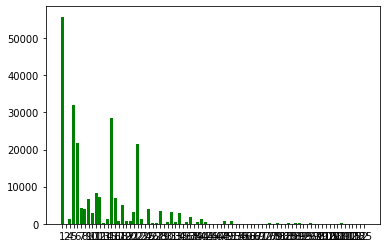

In [90]:
import matplotlib.pyplot as plt
plt.bar(occurences.keys(), occurences.values(), color='g')

<BarContainer object of 81 artists>

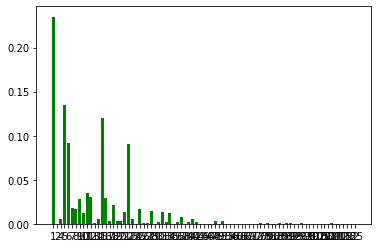

In [91]:
plt.bar(proportions.keys(), proportions.values(), color='g')

# Samples from the dataset and limits the maximum class amount to be 1000

In [92]:
# Initialize a counter for each class to ensure that they don't exceed that amount
threshold = 350
new_dataset_size = 0

class_ref_occurences = {}
for ref in ref_vocab:
  class_ref_occurences[ref] = 0

# Now loop over each ref, checks whether the occurence for that value.
# If lower than the threshold, append all occurences to the dataset right away
# Otherwise, sample from the dataset to get them
sampled_indexes = {}  # Store all indexes to sample
for ref in ref_vocab:
  # Get indexes of all entries with that
  ref_indexes = []
  i = 0
  for entry in target_refs:
    if entry == ref:
      ref_indexes.append(i)
    i += 1

  if occurences[str(ref)] >= threshold:
    # Now randomly sample 1000 indexes
    sampled_indexes[str(ref)] = np.random.choice(ref_indexes, size=threshold, replace=False)

  else:
    # We just get all indexes and no need to sample
    sampled_indexes[str(ref)] = np.array(ref_indexes)

  print(f'ref: {ref} {len(sampled_indexes[str(ref)])}')
  new_dataset_size += len(sampled_indexes[str(ref)])

print(f'new_dataset_size: {new_dataset_size}')

ref: 1 350
ref: 2 1
ref: 4 350
ref: 5 350
ref: 6 350
ref: 7 350
ref: 8 350
ref: 9 350
ref: 10 350
ref: 11 350
ref: 12 350
ref: 13 303
ref: 14 350
ref: 15 350
ref: 16 350
ref: 17 350
ref: 18 350
ref: 19 350
ref: 20 350
ref: 21 350
ref: 22 350
ref: 23 350
ref: 24 46
ref: 25 350
ref: 26 121
ref: 27 311
ref: 28 350
ref: 29 6
ref: 30 350
ref: 31 350
ref: 33 350
ref: 34 350
ref: 35 77
ref: 36 350
ref: 37 350
ref: 38 1
ref: 39 350
ref: 40 350
ref: 42 350
ref: 43 58
ref: 45 68
ref: 46 6
ref: 47 56
ref: 48 350
ref: 49 4
ref: 51 350
ref: 53 2
ref: 54 3
ref: 55 11
ref: 60 4
ref: 63 3
ref: 66 54
ref: 69 79
ref: 71 6
ref: 72 27
ref: 76 223
ref: 78 1
ref: 79 81
ref: 81 1
ref: 82 43
ref: 83 168
ref: 85 16
ref: 86 85
ref: 89 97
ref: 92 33
ref: 95 38
ref: 96 139
ref: 97 10
ref: 98 23
ref: 99 37
ref: 102 75
ref: 105 22
ref: 106 75
ref: 108 6
ref: 109 130
ref: 111 7
ref: 112 17
ref: 115 17
ref: 118 13
ref: 122 51
ref: 125 6
new_dataset_size: 14211


In [101]:
# Now iterate through the old dataset and create a new one
n_episodes = []
n_target_actions = []
n_target_refs = []
n_target_text = []
i = 0
for ref in sampled_indexes:
  print(f'ref {ref}')
  for index in sampled_indexes[ref]:

    row = dataset['train'][int(index)]

    found_action = row['target_actions']
    n_target_actions.append(found_action)

    # Remove all action history duplicates on key pressed
    episode = row['episodes']
    if '{keydown,' in episode:
      parts = episode.split(',}')
      parts = parts[:len(parts)-1]
      parts = set(parts)
      to_remove = []
      for p in parts:
        if 'keydown' in p:
          to_remove.append(p + ',}')
      # Now replace keydown duplicates
      for p in to_remove:
        while p + p in episode:
          episode = episode.replace(p + p, p)
    
    # Remove duplicates click 1
    while '{click,1,}{click,1,}' in episode:
      episode = episode.replace('{click,1,}{click,1,}', '{click,1,}')
    n_episodes.append(episode)

    n_target_refs.append(row['target_refs'])
    n_target_text.append(row['target_text'])
    i += 1

len(n_episodes), len(n_target_actions), len(n_target_refs), len(n_target_text)

ref 1
ref 2
ref 4
ref 5
ref 6
ref 7
ref 8
ref 9
ref 10
ref 11
ref 12
ref 13
ref 14
ref 15
ref 16
ref 17
ref 18
ref 19
ref 20
ref 21
ref 22
ref 23
ref 24
ref 25
ref 26
ref 27
ref 28
ref 29
ref 30
ref 31
ref 33
ref 34
ref 35
ref 36
ref 37
ref 38
ref 39
ref 40
ref 42
ref 43
ref 45
ref 46
ref 47
ref 48
ref 49
ref 51
ref 53
ref 54
ref 55
ref 60
ref 63
ref 66
ref 69
ref 71
ref 72
ref 76
ref 78
ref 79
ref 81
ref 82
ref 83
ref 85
ref 86
ref 89
ref 92
ref 95
ref 96
ref 97
ref 98
ref 99
ref 102
ref 105
ref 106
ref 108
ref 109
ref 111
ref 112
ref 115
ref 118
ref 122
ref 125


(14211, 14211, 14211, 14211)

In [102]:
import pandas as pd
df = {
    "episodes": n_episodes,
    "target_actions": n_target_actions,
    "target_refs": n_target_refs,
    "target_text": n_target_text
}

df = pd.DataFrame(df)
df.to_csv('/content/sample_data/df.csv', index=False)

In [103]:
from datasets import load_dataset
file_dict = {
  "train" : "/content/sample_data/df.csv",
}
df_train = load_dataset("csv", data_files=file_dict)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-6a1be09464198858/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [104]:
df_train.push_to_hub('LucasThil/miniwob_T5_balanced')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

In [107]:
n_episodes[:10]

['{click,1,}{click,11,}{click,11,}{click,1,}i would like to see the important email sherri sent me.<body ref="1"><div ref="2"><div ref="3"><div ref="4"><div ref="5"><span ref="6"></span><span recordingtarget="true" ref="7"></span></div><div ref="8"><div ref="9"><label text="to:"ref="10"></label><input_text ref="11"></input_text></div><div ref="12"><label text="subject:"ref="13"></label><t text="accumsan."ref="14"></t></div></div><div ref="15"><textarea value="urna blandit neque eu. amet risus nec ut. ligula nisl adipiscing. sed porttitor." ref="16"></textarea></d',
 '{click,51,}{click,51,}{click,1,}{"departure city":"salt lake city","destination city":"phoenix","ticket type":"return flight","departure day":10,"returning day":21,"passengers":3,"seat type":"first"<body ref="1"><body ref="1"><a ref="2"></A><div ref="3"><div ref="4"></DIV><form ref="6"><div ref="7"></DIV><div ref="12"><label ref="13"><t text="from"ref="14"></t><input_text value="salt lake city, ut (slc-salt lake city intl.